In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout


In [4]:
# data = pd.read_csv('/content/drive/MyDrive/aapl/AAPL_2006_12_29_to_2024_05_10.csv')
data = pd.read_csv('/Users/lok/Developer/market-forecaster/data/processed/split_adjusted/NVDA_2006_12_29_to_2024_05_10.csv')
# Ensure that the data is in chronological order
data['Date'] = pd.to_datetime(data['Date'])
data.sort_values('Date', inplace=True)

# Selecting the closing prices as the feature to predict
closing_prices = data['Split_Adjusted_Close'].values


In [5]:

scaler = MinMaxScaler(feature_range=(0, 1))
closing_prices = scaler.fit_transform(closing_prices.reshape(-1, 1))


In [6]:
split = int(0.7 * len(closing_prices))
train_data = closing_prices[:split]
test_data = closing_prices[split:]


In [7]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

look_back = 1  # Number of previous time steps to consider for predicting the next step
trainX, trainY = create_dataset(train_data, look_back)
testX, testY = create_dataset(test_data, look_back)

# # Reshape input to be [samples, time steps, features]
# trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
# testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))  # Reshape for LSTM [samples, time steps, features]
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))


In [8]:

with tf.device('/CPU:0'):
# Create and fit the LSTM network
  # model = Sequential()
  # model.add(LSTM(4, input_shape=(1, look_back)))  # 4 LSTM nodes
  # model.add(Dense(1))  # Output layer that predicts the closing price
  # model.compile(loss='mean_squared_error', optimizer='adam')
  # model.fit(trainX, trainY, epochs=50, batch_size=1, verbose=2)
  model = Sequential()
  model.add(LSTM(50, return_sequences=True, input_shape=(look_back, 1)))  # First LSTM layer with more units and return sequences
  # model.add(Dropout(0.2))  # Dropout for regularization
  model.add(LSTM(50, return_sequences=False))  # Second LSTM layer
  model.add(Dense(1))  # Output layer
  model.compile(loss='mean_squared_error', optimizer='adam')
  history = model.fit(trainX, trainY, epochs=100, batch_size=32, verbose=2, validation_data=(testX, testY))  # Increased batch size and epochs


Epoch 1/100


/Users/lok/miniconda3/envs/tensorflow_env/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


96/96 - 1s - 12ms/step - loss: 2.9155e-04 - val_loss: 0.0503
Epoch 2/100
96/96 - 0s - 1ms/step - loss: 5.3835e-05 - val_loss: 1.0959e-04
Epoch 3/100
96/96 - 0s - 1ms/step - loss: 4.4404e-07 - val_loss: 1.2539e-04
Epoch 4/100
96/96 - 0s - 1ms/step - loss: 4.2554e-07 - val_loss: 1.1473e-04
Epoch 5/100
96/96 - 0s - 1ms/step - loss: 4.7412e-07 - val_loss: 1.2166e-04
Epoch 6/100
96/96 - 0s - 1ms/step - loss: 4.6307e-07 - val_loss: 1.1717e-04
Epoch 7/100
96/96 - 0s - 1ms/step - loss: 5.0973e-07 - val_loss: 1.2275e-04
Epoch 8/100
96/96 - 0s - 1ms/step - loss: 4.4948e-07 - val_loss: 1.1267e-04
Epoch 9/100
96/96 - 0s - 1ms/step - loss: 4.8413e-07 - val_loss: 1.2603e-04
Epoch 10/100
96/96 - 0s - 1ms/step - loss: 5.0817e-07 - val_loss: 1.2037e-04
Epoch 11/100
96/96 - 0s - 996us/step - loss: 5.0715e-07 - val_loss: 1.3122e-04
Epoch 12/100
96/96 - 0s - 1ms/step - loss: 4.3643e-07 - val_loss: 1.2374e-04
Epoch 13/100
96/96 - 0s - 1ms/step - loss: 5.5940e-07 - val_loss: 1.2305e-04
Epoch 14/100
96/96 - 

In [11]:
model.save_weights('/Users/lok/Developer/market-forecaster/models/nvidia.weights.h5')


In [12]:
train_predict = model.predict(trainX)
test_predict = model.predict(testX)

# Invert predictions
train_predict = scaler.inverse_transform(train_predict)
trainY = scaler.inverse_transform([trainY])
test_predict = scaler.inverse_transform(test_predict)
testY = scaler.inverse_transform([testY])


96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 352us/step


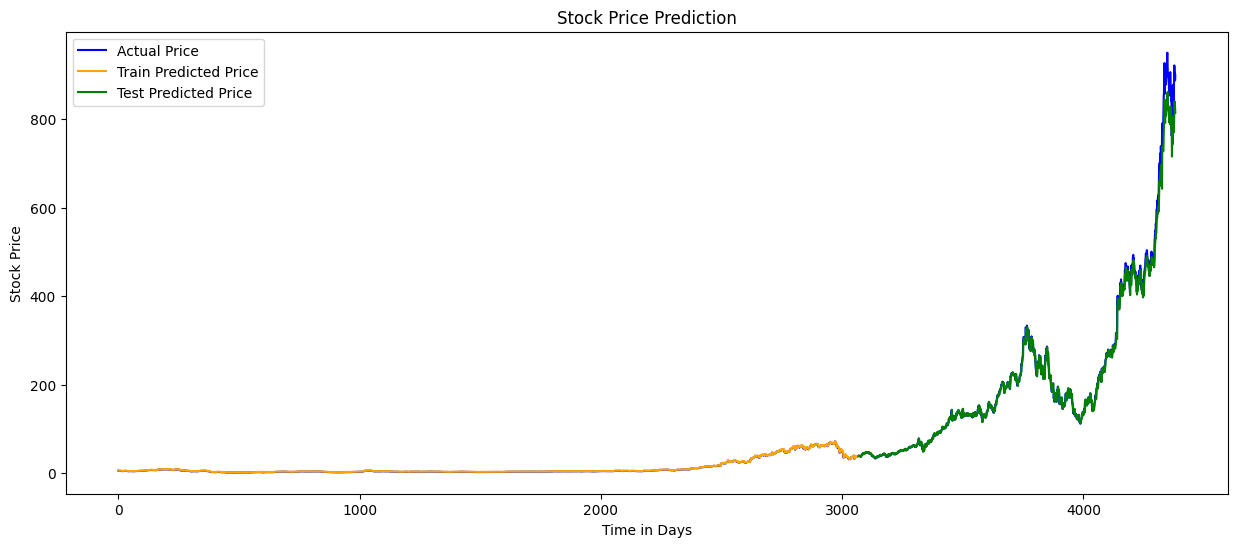

In [13]:

# Actual vs. Predicted on the training data
trainPredictPlot = np.empty_like(closing_prices)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict) + look_back, :] = train_predict

# Actual vs. Predicted on the testing data
testPredictPlot = np.empty_like(closing_prices)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict) + (look_back * 2):len(closing_prices), :] = test_predict

# Plotting
plt.figure(figsize=(15, 6))
plt.plot(scaler.inverse_transform(closing_prices), label='Actual Price', color='blue')
plt.plot(trainPredictPlot, label='Train Predicted Price', color='orange')
plt.plot(testPredictPlot, label='Test Predicted Price', color='green')
plt.title('Stock Price Prediction')
plt.xlabel('Time in Days')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


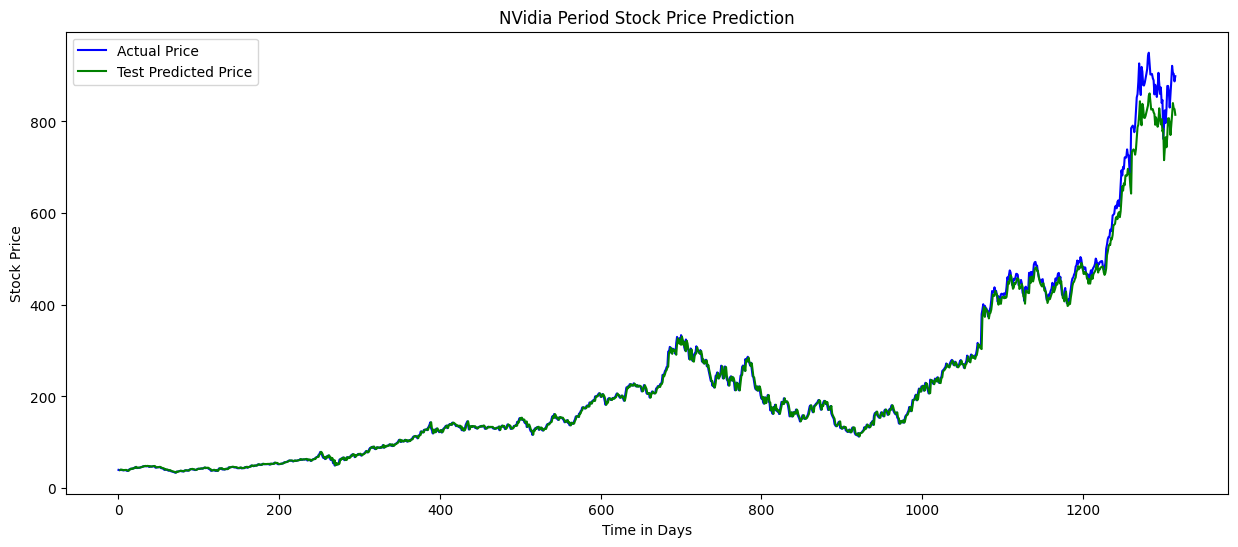

In [14]:


# Calculate the start index for the test data in the full dataset
test_start_index = len(closing_prices) - len(test_predict) - look_back * 2

# Create arrays for plotting that only include the test period
actual_test_prices = scaler.inverse_transform(closing_prices[test_start_index:])
predicted_test_prices = np.empty_like(actual_test_prices)
predicted_test_prices[:, :] = np.nan  # Initialize with NaN
predicted_test_prices[look_back * 2:] = test_predict  # Place predictions correctly aligned with the actual prices

# Plotting
plt.figure(figsize=(15, 6))
plt.plot(actual_test_prices, label='Actual Price', color='blue')
plt.plot(predicted_test_prices, label='Test Predicted Price', color='green')
plt.title('NVidia Period Stock Price Prediction')
plt.xlabel('Time in Days')
plt.ylabel('Stock Price')
plt.legend()
plt.show()
